In [1]:
!pip install mdtraj
#!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md
import sys
sys.path.append('/content/drive/MyDrive/AF2RAVE-Glide/kinase_Aloop/')
import os
import kinaseCVs as kcv

**Load SPIB coordinates**

In [4]:
round = '/content/drive/MyDrive/AF2RAVE-Glide/SPIB_std_filter/round1'
op_id = [int(x) for x in np.loadtxt(f'{round}/op_id.txt')]

op_max = np.load(f"{round}/DDR1_input/max_unb.npy")
op_min = np.load(f"{round}/DDR1_input/min_unb.npy")
lag = 8000
dt = f"{lag*2e-3} ns"
prefix=f"{round}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_b=0.0500_learn=0.000100_"
weights=np.load(prefix+"z_mean_encoder_weight0.npy")

wts = weights/(op_max-op_min)
print(op_id)
print(wts)

[1, 2, 3, 7, 8, 10, 11, 12]
[[ 0.09284084  0.04113295 -0.31039463  0.09656175 -0.02102127 -0.10813012
  -0.04166198  0.01493557]
 [ 0.11358153  0.13575025  0.03890331  0.34705924  0.11752161 -0.32470332
   0.20966233 -0.09062353]]


In [5]:
import networkx as nx
from matplotlib import cm

In [6]:
import glob
import re
import pickle
from kinaseCVs import resids_Abl1
from kinaseCVs import resids_DDR1
xbin = np.linspace(-1,0,51)
ybin = np.linspace(0.3,1.5,51)

**Abl1 unbiased MD from tAF2**

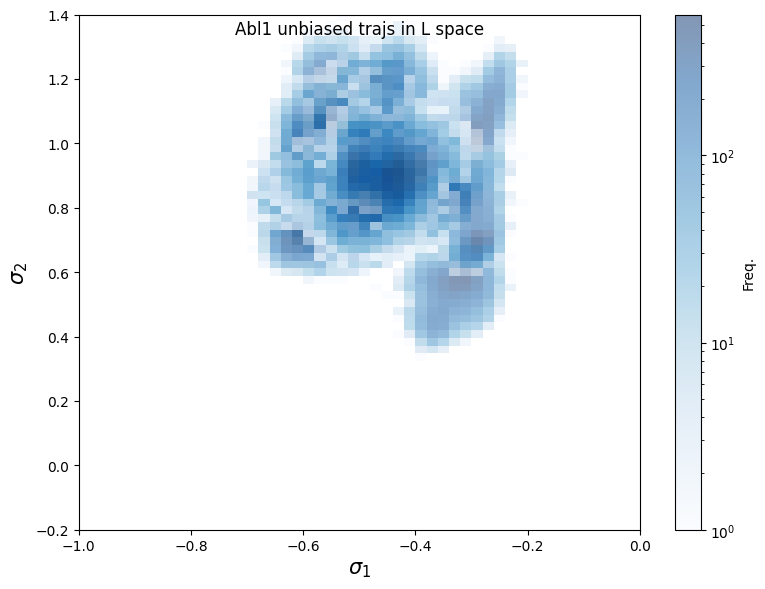

In [7]:
folder = '/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/unbiased_MD'
plt.figure(figsize=(8, 6))

file_paths = glob.glob(f'{folder}/cvs/*')
for file in file_paths:
    cv_array = np.loadtxt(file)
    plt.hist2d(x=cv_array.T[0], y=cv_array.T[1],cmap="Blues", norm='log',alpha=0.5, bins = [xbin,ybin])

plt.title('Abl1 unbiased trajs in L space',y=1.0, pad=-14)
plt.xlabel("$\sigma_1$",fontsize=15)
plt.ylabel("$\sigma_2$",fontsize=15)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
plt.colorbar(label='Freq.')
plt.tight_layout()

In [8]:
G = nx.Graph()
# node positions
pos = {}
file_paths = glob.glob(f'{folder}/cvs/*')
for ii in range(len(file_paths)):
    cv_array = np.loadtxt(file_paths[ii])
    pos[ii] = (np.mean(cv_array.T[0]), np.mean(cv_array.T[1]))
G.add_nodes_from(pos.keys())

edge = []
edge_widths = []
xbin = np.linspace(-1,0,51)
ybin = np.linspace(0.3,1.5,51)

for ii in range(len(file_paths)):
    cv_array1 = np.loadtxt(file_paths[ii])
    hist1, _, _ = np.histogram2d(cv_array1.T[0], cv_array1.T[1], bins = [xbin,ybin])
    a = np.concatenate(hist1)
    v1 = np.where(a>0, np.log(a), 0)
    for jj in range(ii+1,len(file_paths)):
        edge.append((ii,jj))
        cv_array2 = np.loadtxt(file_paths[jj])
        hist2, _, _ = np.histogram2d(cv_array2.T[0], cv_array2.T[1], bins = [xbin,ybin])
        a = np.concatenate(hist2)
        v2 = np.where(a>0, np.log(a), 0)
        edge_widths.append(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2))
for ed, width in zip(edge, edge_widths):
    G.add_edge(*ed, width=width)

<ipython-input-8-511307f87ba7>:19: RuntimeWarning: divide by zero encountered in log
  v1 = np.where(a>0, np.log(a), 0)
<ipython-input-8-511307f87ba7>:25: RuntimeWarning: divide by zero encountered in log
  v2 = np.where(a>0, np.log(a), 0)


<ipython-input-9-51a49f5ebfe9>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


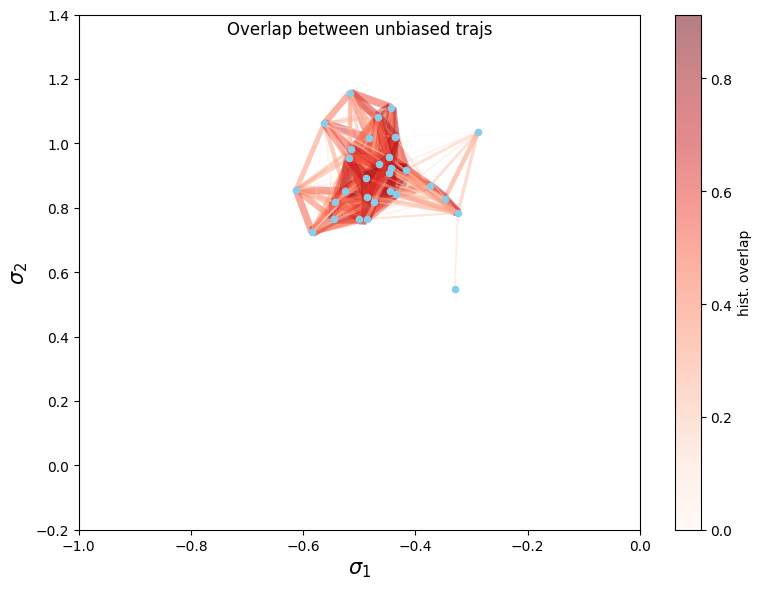

In [9]:
# Draw the graph
fig, ax = plt.subplots(figsize=(8, 6))
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue',ax=ax)

# Draw edges with specified widths
widths = [G[edge[0]][edge[1]]['width']*10 for edge in G.edges()]
cmap = cm.get_cmap('Reds')
g_edge = nx.draw_networkx_edges(G, pos, width=widths, edge_color=edge_widths, edge_cmap=cmap, alpha=0.5,ax=ax)

# Show the plot
#plt.title("Graph with Edge Widths")
plt.title('Overlap between unbiased trajs',y=1.0, pad=-14)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel("$\sigma_1$",fontsize=15)
plt.ylabel("$\sigma_2$",fontsize=15)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
plt.colorbar(g_edge, label='hist. overlap')
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/AF2RAVE-Glide/Abl1_lspace_unb_G.png",dpi=300)

In [10]:
cvs_array =[]
for ii in range(len(file_paths)):
    cvs_array.append(np.loadtxt(file_paths[ii]))
cvs_array = np.concatenate(cvs_array)
hist, xedges, yedges = np.histogram2d(cvs_array.T[0], cvs_array.T[1], bins = [xbin,ybin], density=True)
tmpx = xbin+0.01
tmpy = ybin+0.012
X, Y = np.meshgrid(tmpx[:-1],tmpy[:-1])
pmf = hist.T.flatten()
pmf = np.where(pmf>0, -np.log(pmf)*2.49, 999999999999)
pmf = pmf - np.min(pmf)

df = pd.DataFrame()
df['xx'] = X.flatten()
df['yy'] = Y.flatten()
df['pmf'] = pmf
df.to_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/unbiased_MD/pmf.csv', index=False)

<ipython-input-10-4f8805d34346>:10: RuntimeWarning: divide by zero encountered in log
  pmf = np.where(pmf>0, -np.log(pmf)*2.49, 999999999999)


**Assign PMF values for tAF2 structures**

In [22]:
mcs_ct = 0.7
temps = ['3OXZ','2HYY']
rank = pd.DataFrame()
pres = []
file_list = glob.glob('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/frames/*')
for file in file_list:
    pres.append(os.path.basename(file)[:-4])
rank['pres'] = pres
for ii, temp in enumerate(temps):
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        marks.append(np.min(sub[f'{temp}_l_RMSD']))
    rank[f'l_rmsd_{temp}'] = marks

In [23]:
tls_array = []
for file in file_list:
    traj = md.load(file)
    cv=kcv.kinase_cvs("Abl1",traj.top,resids_Abl1,traj)
    ops = []
    for j in op_id:
        ops.extend(cv.allcvs[j].traj)
    tls_array.append(np.dot(ops, wts.T))
tls_array=np.array(tls_array)
rank['sigma1']=tls_array.T[0]
rank['sigma2']=tls_array.T[1]

In [24]:
a=pd.read_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/unbiased_MD/pmf.csv', header=0, comment='#')
ct=0.05
pmfs = []
tls = tls_array
for tt in range(len(tls)):
    print(pres[tt], tls[tt])
    tx=tls[tt][0]
    ty=tls[tt][1]
    b=a[(a.xx>tx-ct) & (a.xx<tx+ct) & (a.yy>ty-ct) & (a.yy<ty+ct)]
    cand = []
    cand.append(list(b.xx))
    cand.append(list(b.yy))
    cand = np.transpose(cand)
    out_id = np.argmin(np.linalg.norm(tls[tt]-cand, axis=1))
    pmfs.append(np.round(b.iloc[out_id]['pmf'], 3))
rank['pmf'] = pmfs

pred_1_ifdm [-0.51461857  0.6511677 ]
pred_1_ifdd [-0.42459928  0.76833819]
pred_2_ifdi [-0.46896052  0.78045838]
pred_1_ifdi [-0.47899361  0.84128142]
pred_2_ifdm [-0.51718734  0.6910502 ]
pred_1_ifdc [-0.51527925  0.67728774]
pred_1_ifdj [-0.45045776  0.73616644]
pred_1_ifda [-0.49575237  0.81371974]
pred_2_ifdf [-0.47021821  0.83684221]
pred_1_ifdf [-0.46826685  0.86309954]
pred_1_ifdb [-0.58858023  0.66398476]
pred_2_ifdg [-0.46847036  0.70425035]
pred_1_ifdo [-0.44902569  0.67827838]
pred_1_ifdk [-0.5233298   0.74469242]
pred_1_ifdg [-0.45976181  0.70601472]
pred_2_ifda [-0.49943501  0.78388892]
pred_1_ifdh [-0.51905097  0.65220169]
pred_2_ifdj [-0.50128328  0.72807317]
pred_2_ifdb [-0.51576485  0.66147678]
pred_2_ifdn [-0.49947274  0.77614808]
pred_1_ifdl [-0.56834764  0.75406154]
pred_2_ifdc [-0.52556758  0.67245643]
pred_1_ifde [-0.52929069  0.95428242]
pred_1_ifdn [-0.50193337  0.80019004]
pred_2_ifdo [-0.45131931  0.73175703]
pred_2_ifdk [-0.5151269   0.73782406]
pred_2_ifdh 

In [25]:
pmf_rank = rank.sort_values(by=['pmf'],ignore_index=True)
pmf_rank.to_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/unbiased_MD/pmf_rank.csv', index=False)

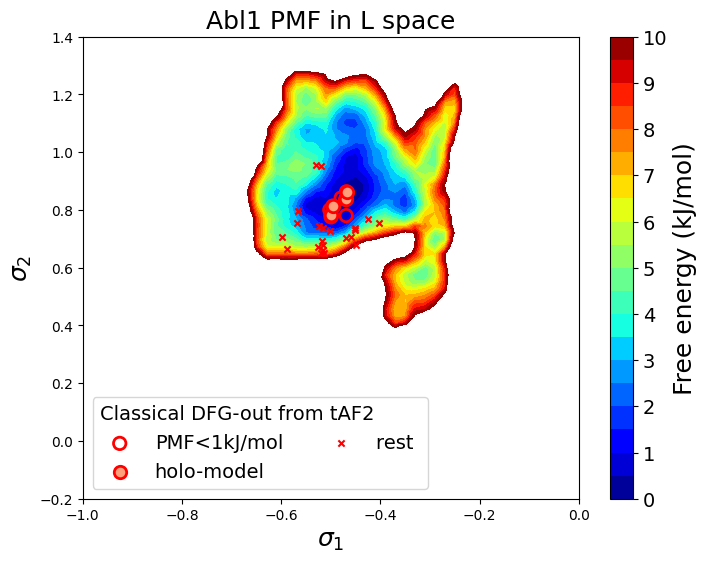

In [26]:
pmf_rank = pd.read_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/unbiased_MD/pmf_rank.csv')
# pmf >1
cross = [pmf_rank[pmf_rank.pmf >1].sigma1.to_list(), pmf_rank[pmf_rank.pmf >1].sigma2.to_list()]
# pmf <1
circle = [pmf_rank[pmf_rank.pmf <1].sigma1.to_list(), pmf_rank[pmf_rank.pmf <1].sigma2.to_list()]
# winner
winner = [pmf_rank[pmf_rank.l_rmsd_3OXZ <3].sigma1.to_list(), pmf_rank[pmf_rank.l_rmsd_3OXZ <3].sigma2.to_list()]

plt.figure(figsize=(8, 6))
a=pd.read_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1/unbiased_MD/pmf.csv', header=0, comment='#')
minp=np.min(a.pmf)
b=a[a.pmf<9999]
levels=np.arange(0, 10.5, 0.5)
ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
plt.scatter(circle[0],circle[1], marker='o',linewidths=2,c='none',edgecolors='r',s=80,label='PMF<1kJ/mol')
plt.scatter(winner[0],winner[1],marker='o',s=80, facecolors='lightsalmon', edgecolors='r',linewidths=2, label='holo-model')
plt.scatter(cross[0],cross[1],marker='x',linewidths=1.5,c='r',s=20,label='rest ')

plt.title('Abl1 PMF in L space',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1$",fontsize=18)
plt.ylabel("$\sigma_2$",fontsize=18)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
cbar = plt.colorbar(CS)
cbar.set_label(label='Free energy (kJ/mol)',size=18)

plt.legend(fontsize=14, loc='lower left', title='Classical DFG-out from tAF2',title_fontsize=14,alignment='left',ncol=2)
cbar.set_ticks(np.arange(0, 10.5, 1))
cbar.ax.tick_params(labelsize=14)
plt.savefig(f"/content/drive/MyDrive/AF2RAVE-Glide/Abl1_pmf_unbiased.png",dpi=300)

**DDR1 unbiased MD from classical DFG-out in rMSA AF2**

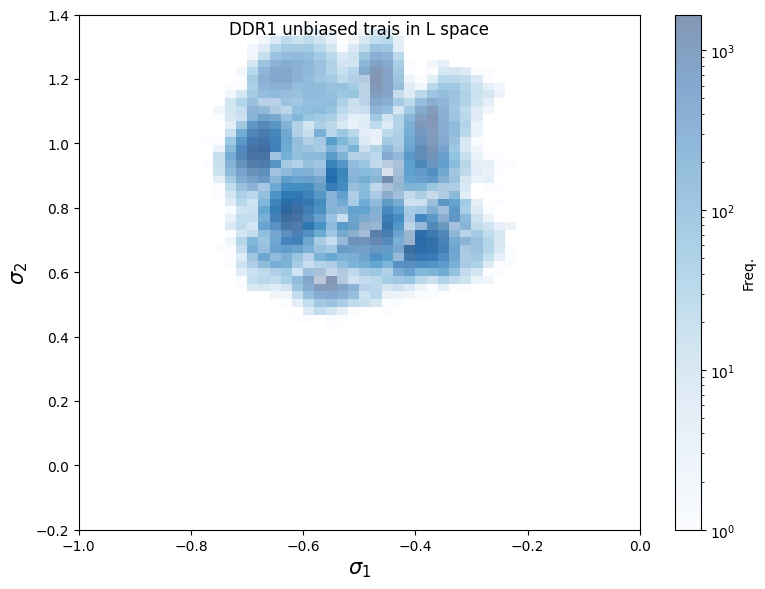

In [16]:
folder = '/content/drive/MyDrive/AF2RAVE-Glide/tAF2_DDR1'
plt.figure(figsize=(8, 6))

file_paths = glob.glob(f'{folder}/cvs/*')
for file in file_paths:
    cv_array = np.loadtxt(file)
    plt.hist2d(x=cv_array.T[0], y=cv_array.T[1],cmap="Blues", norm='log',alpha=0.5, bins = [xbin,ybin])

plt.title('DDR1 unbiased trajs in L space',y=1.0, pad=-14)
plt.xlabel("$\sigma_1$",fontsize=15)
plt.ylabel("$\sigma_2$",fontsize=15)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
plt.colorbar(label='Freq.')
plt.tight_layout()

In [17]:
G = nx.Graph()
# node positions
pos = {}
file_paths = glob.glob(f'{folder}/cvs/*')
for ii in range(len(file_paths)):
    cv_array = np.loadtxt(file_paths[ii])
    pos[ii] = (np.mean(cv_array.T[0]), np.mean(cv_array.T[1]))
G.add_nodes_from(pos.keys())

edge = []
edge_widths = []
xbin = np.linspace(-1,0,51)
ybin = np.linspace(0.3,1.5,51)

for ii in range(len(file_paths)):
    cv_array1 = np.loadtxt(file_paths[ii])
    hist1, _, _ = np.histogram2d(cv_array1.T[0], cv_array1.T[1], bins = [xbin,ybin])
    a = np.concatenate(hist1)
    v1 = np.where(a>0, np.log(a), 0)
    for jj in range(ii+1,len(file_paths)):
        edge.append((ii,jj))
        cv_array2 = np.loadtxt(file_paths[jj])
        hist2, _, _ = np.histogram2d(cv_array2.T[0], cv_array2.T[1], bins = [xbin,ybin])
        a = np.concatenate(hist2)
        v2 = np.where(a>0, np.log(a), 0)
        edge_widths.append(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2))
for ed, width in zip(edge, edge_widths):
    G.add_edge(*ed, width=width)

<ipython-input-17-511307f87ba7>:19: RuntimeWarning: divide by zero encountered in log
  v1 = np.where(a>0, np.log(a), 0)
<ipython-input-17-511307f87ba7>:25: RuntimeWarning: divide by zero encountered in log
  v2 = np.where(a>0, np.log(a), 0)


<ipython-input-18-495e091ea2a7>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


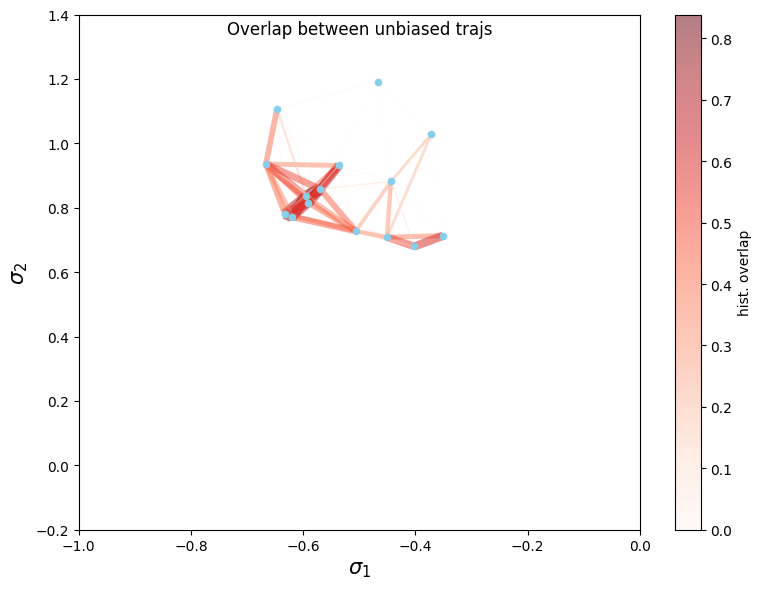

In [18]:
# Draw the graph
fig, ax = plt.subplots(figsize=(8, 6))
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue',ax=ax)

# Draw edges with specified widths
widths = [G[edge[0]][edge[1]]['width']*10 for edge in G.edges()]
cmap = cm.get_cmap('Reds')
g_edge = nx.draw_networkx_edges(G, pos, width=widths, edge_color=edge_widths, edge_cmap=cmap, alpha=0.5,ax=ax)

# Show the plot
#plt.title("Graph with Edge Widths")
plt.title('Overlap between unbiased trajs',y=1.0, pad=-14)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel("$\sigma_1$",fontsize=15)
plt.ylabel("$\sigma_2$",fontsize=15)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
plt.colorbar(g_edge, label='hist. overlap')
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/AF2RAVE-Glide/DDR1_lspace_unb_G.png",dpi=300)

In [19]:
cvs_array =[]
for ii in range(len(file_paths)):
    cvs_array.append(np.loadtxt(file_paths[ii]))
cvs_array = np.concatenate(cvs_array)
hist, xedges, yedges = np.histogram2d(cvs_array.T[0], cvs_array.T[1], bins = [xbin,ybin], density=True)
tmpx = xbin+0.01
tmpy = ybin+0.012
X, Y = np.meshgrid(tmpx[:-1],tmpy[:-1])
pmf = hist.T.flatten()
pmf = np.where(pmf>0, -np.log(pmf)*2.49, 999999999999)
pmf = pmf - np.min(pmf)

df = pd.DataFrame()
df['xx'] = X.flatten()
df['yy'] = Y.flatten()
df['pmf'] = pmf
df.to_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_DDR1/pmf.csv', index=False)

<ipython-input-19-cabf9a820c4f>:10: RuntimeWarning: divide by zero encountered in log
  pmf = np.where(pmf>0, -np.log(pmf)*2.49, 999999999999)


In [20]:
mcs_ct = 0.7
temps = ['3ZOS','4BKJ']
rank = pd.DataFrame()
pres = []
file_list = glob.glob('/content/drive/MyDrive/AF2RAVE-Glide/IFD_valid/DDR1/frames/*')
for file in file_list:
    pres.append(os.path.basename(file)[:-4])
rank['pres'] = pres
for ii, temp in enumerate(temps):
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'/content/drive/MyDrive/AF2RAVE-Glide/IFD_valid/DDR1/{pre[6:]}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        marks.append(np.min(sub[f'{temp}_l_RMSD']))
    rank[f'l_rmsd_{temp}'] = marks

tls_array = []
for file in file_list:
    traj = md.load(file)
    cv=kcv.kinase_cvs("DDR1",traj.top,resids_DDR1,traj)
    ops = []
    for j in op_id:
        ops.extend(cv.allcvs[j].traj)
    tls_array.append(np.dot(ops, wts.T))
tls_array=np.array(tls_array)
rank['sigma1']=tls_array.T[0]
rank['sigma2']=tls_array.T[1]

a=pd.read_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_DDR1/pmf.csv', header=0, comment='#')
ct=0.05
pmfs = []
tls = tls_array
for tt in range(len(tls)):
    print(pres[tt], tls[tt])
    tx=tls[tt][0]
    ty=tls[tt][1]
    b=a[(a.xx>tx-ct) & (a.xx<tx+ct) & (a.yy>ty-ct) & (a.yy<ty+ct)]
    cand = []
    cand.append(list(b.xx))
    cand.append(list(b.yy))
    cand = np.transpose(cand)
    out_id = np.argmin(np.linalg.norm(tls[tt]-cand, axis=1))
    pmfs.append(np.round(b.iloc[out_id]['pmf'], 3))
rank['pmf'] = pmfs

pmf_rank = rank.sort_values(by=['pmf'],ignore_index=True)
pmf_rank.to_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_DDR1/pmf_rank.csv', index=False)

frame_605 [-0.52783814  0.68571519]
frame_1130 [-0.46794338  0.62159761]
frame_1107 [-0.58676527  0.73262632]
frame_1137 [-0.41946371  0.74328488]
frame_960 [-0.46762665  0.91877302]
frame_307 [-0.57571144  0.68653615]
frame_671 [-0.57349605  0.79807275]
frame_915 [-0.55038822  0.78134381]
frame_901 [-0.47950487  0.82218781]
frame_940 [-0.54569608  0.7321746 ]
frame_1134 [-0.45740984  0.84440168]
frame_1007 [-0.50833604  0.73168544]
frame_1001 [-0.49383591  0.79589494]
frame_854 [-0.54817125  0.97467324]
frame_74 [-0.54009923  0.8250241 ]


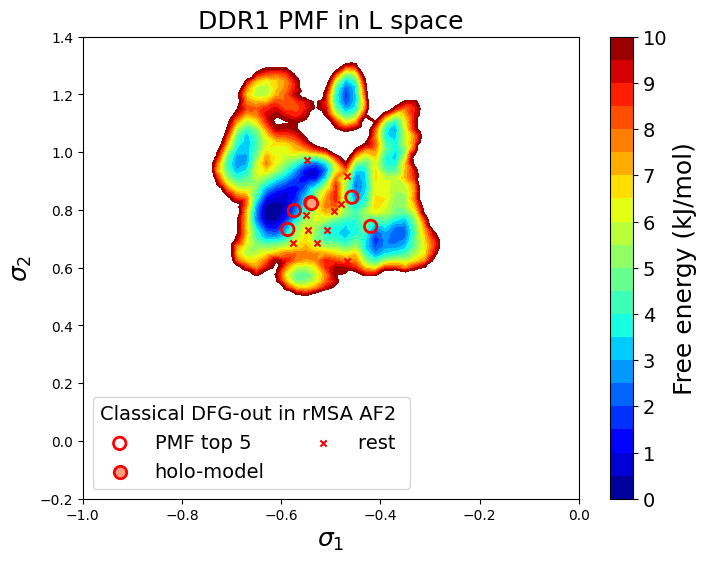

In [21]:
pmf_rank = pd.read_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_DDR1/pmf_rank.csv')
# pmf rest
cross = [pmf_rank.iloc[5:].sigma1.to_list(), pmf_rank.iloc[5:].sigma2.to_list()]
# pmf top5
circle = [pmf_rank.iloc[:5].sigma1.to_list(), pmf_rank.iloc[:5].sigma2.to_list()]
# winner
winner = [pmf_rank[pmf_rank.l_rmsd_3ZOS <3].sigma1.to_list(), pmf_rank[pmf_rank.l_rmsd_3ZOS <3].sigma2.to_list()]

plt.figure(figsize=(8, 6))
a=pd.read_csv('/content/drive/MyDrive/AF2RAVE-Glide/tAF2_DDR1/pmf.csv', header=0, comment='#')
minp=np.min(a.pmf)
b=a[a.pmf<9999]
levels=np.arange(0, 10.5, 0.5)
ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
plt.scatter(circle[0],circle[1], marker='o',linewidths=2,c='none',edgecolors='r',s=80,label='PMF top 5')
plt.scatter(winner[0],winner[1],marker='o',s=80, facecolors='lightsalmon', edgecolors='r',linewidths=2, label='holo-model')
plt.scatter(cross[0],cross[1],marker='x',linewidths=1.5,c='r',s=20,label='rest ')

plt.title('DDR1 PMF in L space',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1$",fontsize=18)
plt.ylabel("$\sigma_2$",fontsize=18)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
cbar = plt.colorbar(CS)
cbar.set_label(label='Free energy (kJ/mol)',size=18)

plt.legend(fontsize=14, loc='lower left', title='Classical DFG-out in rMSA AF2',title_fontsize=14,alignment='left',ncol=2)
cbar.set_ticks(np.arange(0, 10.5, 1))
cbar.ax.tick_params(labelsize=14)
plt.savefig(f"/content/drive/MyDrive/AF2RAVE-Glide/DDR1_pmf_unbiased.png",dpi=300)